<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import numpy as np
import itertools
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegressionCV
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import pandas as pd

np.set_printoptions(precision=3)
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-10-06 15:00:28--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.08s   

2020-10-06 15:00:29 (269 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv', index_col=0)
df.head()

,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 399
Data columns (total 9 columns):
Unnamed: 0.1      346 non-null int64
loan_status       346 non-null object
Principal         346 non-null int64
terms             346 non-null int64
effective_date    346 non-null object
due_date          346 non-null object
age               346 non-null int64
education         346 non-null object
Gender            346 non-null object
dtypes: int64(4), object(5)
memory usage: 27.0+ KB


In [5]:
df.shape

(346, 9)

In [6]:
df.columns

Index(['Unnamed: 0.1', 'loan_status', 'Principal', 'terms', 'effective_date',
       'due_date', 'age', 'education', 'Gender'],
      dtype='object')

In [7]:
df = df.drop(columns=['Unnamed: 0.1'])  #drop useless col

### Convert to date time object 

In [8]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [9]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

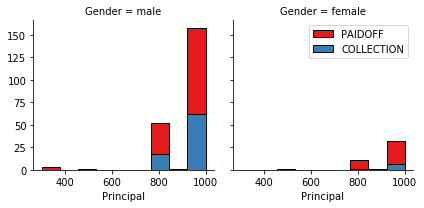

In [10]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

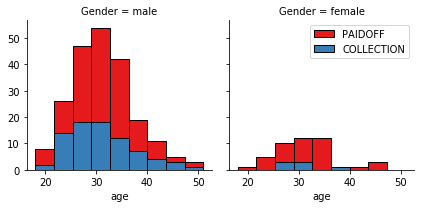

In [11]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

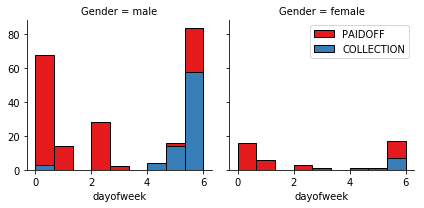

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [17]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
2,1000,30,33,1,Bechalor
3,1000,15,27,0,college
4,1000,30,28,1,college
6,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
2,1000,30,33,1,0,1,0,0
3,1000,15,27,0,0,0,0,1
4,1000,30,28,1,1,0,0,1
6,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [128]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
2,1000,30,33,1,0,1,0,0
3,1000,15,27,0,0,0,0,1
4,1000,30,28,1,1,0,0,1
6,1000,30,29,0,1,0,0,1


What are our lables?

In [32]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [22]:
#X = preprocessing.StandardScaler().fit(X).transform(X)
#X[0:5]

#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
#print ('Train set:', X_train.shape,  y_train.shape)
#print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [33]:
#KNN
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

Ks = 15
weight = ['distance', 'uniform']
mean_acc = np.zeros((Ks-1))
logloss = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
f1_score = np.zeros((Ks-1))
jacc_score = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors=n, weights=weight[0]).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
    logloss[n-1] = metrics.log_loss(y_test, neigh.predict_proba(X_test))
    
    f1_score[n-1] = metrics.f1_score(y_test, yhat, pos_label='PAIDOFF', average='binary')
    
    jacc_score[n-1] = metrics.jaccard_similarity_score(y_test, yhat)
    
    ConfustionMx.append(confusion_matrix(y_test, yhat))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


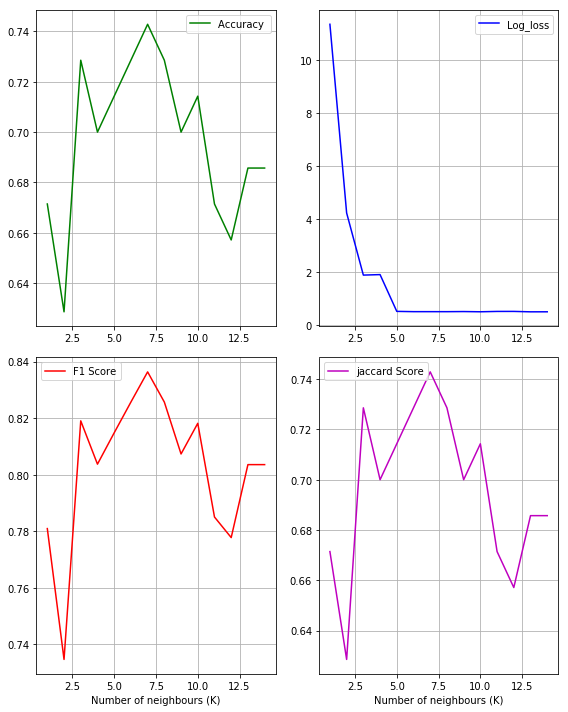

In [34]:
fig = plt.figure(figsize=(8,10))
plt.subplot(2,2,1)
plt.plot(range(1,Ks),mean_acc,'g', label = 'Accuracy ');
plt.legend()
plt.grid(b=True, axis='both')

plt.subplot(2,2,2)
plt.plot(range(1,Ks),logloss,'b', label = 'Log_loss');
plt.legend()
plt.grid(b=True, axis='both')

plt.subplot(2,2,3)
plt.plot(range(1,Ks), f1_score,'r', label = 'F1 Score');
plt.legend(loc = 'upper left')
plt.xlabel('Number of neighbours (K)')
plt.grid(b=True, axis='both')

plt.subplot(2,2,4)
plt.plot(range(1,Ks), jacc_score,'m', label = 'jaccard Score');
plt.legend(loc = 'upper left')
plt.xlabel('Number of neighbours (K)')
plt.grid(b=True, axis='both')


plt.tight_layout()

In [35]:
print ("The best accuracy was: {0:.3f} with k={k}".format(mean_acc.max(), k=mean_acc.argmax()+1))
print ("The best log_loss was: {0:.3f} with k={k}".format(logloss.min(), k=logloss.argmin()+1))
print ("The best f1_score was: {0:.3f} with k={k}".format(f1_score.max(), k=f1_score.argmax()+1))
print ("The best Jaccard_score was: {0:.3f} with k={k}".format(jacc_score.max(), k=jacc_score.argmax()+1))

The best accuracy was: 0.743 with k=7
The best log_loss was: 0.494 with k=13
The best f1_score was: 0.836 with k=7
The best Jaccard_score was: 0.743 with k=7


# Decision Tree

In [50]:
#DecisionTrees

min_depth = 2
max_depth = 16
N = max_depth-min_depth+1
depth = list(range(min_depth,max_depth+1))
mean_acc = np.zeros(N)
train_acc = np.zeros(N)
std_acc = np.zeros(N)
jacc_score = np.zeros(N)
f1_score = np.zeros(N)
logloss = np.zeros(N)
ConfustionMx = [];
for n in range(N):
    
    #Train Model and Predict  
    rfc = RandomForestClassifier(n_estimators=5,
                                max_depth=depth[n],
                                min_samples_split = 0.02,
                                min_samples_leaf = 0.01,
                                max_features='auto')
    rfc.fit(X_train, y_train)
    yhat = rfc.predict(X_test)
    mean_acc[n] = metrics.accuracy_score(y_test, yhat)
    jacc_score[n] = metrics.jaccard_similarity_score(y_test, yhat)
    logloss[n] = metrics.log_loss(y_test, rfc.predict_proba(X_test))
    f1_score[n] = metrics.f1_score(y_test, yhat, pos_label='PAIDOFF', average='binary')
    
    ConfustionMx.append(confusion_matrix(y_test, yhat))

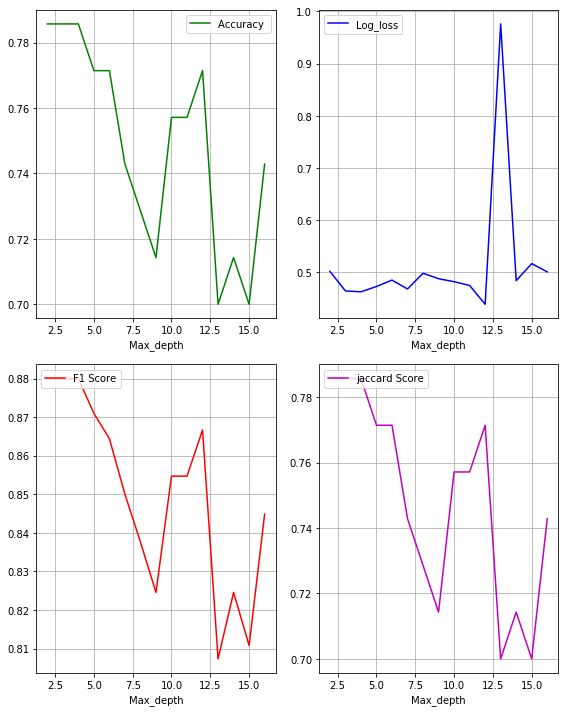

In [51]:
fig = plt.figure(figsize=(8,10))
plt.subplot(2,2,1)
plt.plot(range(min_depth,max_depth+1),mean_acc,'g', label = 'Accuracy ');
plt.legend()
plt.xlabel('Max_depth')
plt.grid(b=True, axis='both')

plt.subplot(2,2,2)
plt.plot(range(min_depth,max_depth+1),logloss,'b', label = 'Log_loss');
plt.legend()
plt.xlabel('Max_depth')
plt.grid(b=True, axis='both')

plt.subplot(2,2,3)
plt.plot(range(min_depth,max_depth+1), f1_score,'r', label = 'F1 Score');
plt.legend(loc = 'upper left')
plt.xlabel('Max_depth')
plt.grid(b=True, axis='both')

plt.subplot(2,2,4)
plt.plot(range(min_depth,max_depth+1), jacc_score,'m', label = 'jaccard Score');
plt.legend(loc = 'upper left')
plt.xlabel('Max_depth')
plt.grid(b=True, axis='both')

plt.tight_layout()

In [52]:
print ("The best accuracy was: {0:.3f} with depth: {depth}".format(mean_acc.max(), depth=depth[mean_acc.argmax()]))
print ("The best f1_score was: {0:.3f} with depth: {depth}".format(f1_score.max(), depth=depth[f1_score.argmax()]))
print ("The best log_loss was: {0:.3f} with depth: {depth}".format(logloss.min(), depth=depth[logloss.argmin()]))

The best accuracy was: 0.786 with depth: 2
The best f1_score was: 0.880 with depth: 2
The best log_loss was: 0.438 with depth: 12


# Support Vector Machine

In [60]:
#SVM
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

C = 1.0  # SVM regularization parameter
ConfustionMx = np.zeros((1,2,2))
accuracy = np.array([])
f1_score = np.array([])

models = (svm.SVC(kernel='linear', C=C, max_iter=5000),
          svm.LinearSVC(C=C, max_iter=5000),
          svm.SVC(kernel='rbf', gamma=0.7, C=C, max_iter=5000),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C, max_iter=5000))

for clf in models:
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    accuracy = np.append(accuracy, metrics.accuracy_score(y_test, y_hat))
    f1_score = np.append(f1_score, metrics.f1_score(y_test, y_hat, pos_label='COLLECTION'))
    ConfustionMx = np.append(ConfustionMx, confusion_matrix(y_test, yhat).reshape(1,2,2), axis=0)

ConfustionMx = ConfustionMx[1:,:,:]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and bein

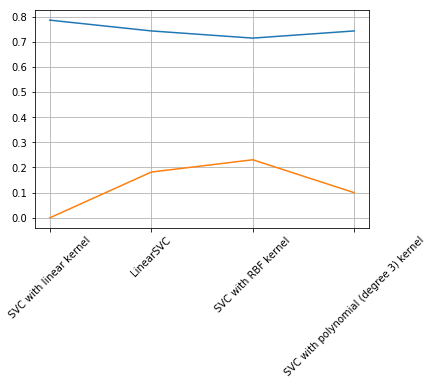

In [61]:
# title for the plots
x_labels = ('SVC with linear kernel',
          'LinearSVC',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
plt.plot(x_labels, accuracy, label = 'Accuracy');
plt.xticks(rotation=45);
plt.grid(b=True, axis='both')

plt.plot(x_labels, f1_score, label = 'f1_score');
plt.xticks(rotation=45);
plt.grid(b=True, axis='both')

# Logistic Regression

In [74]:
#LogReg

C = 10 # LR inverse of regularization strength
ConfustionMx = np.empty((1,2,2))
accuracy = np.array([])
f1_score = np.array([])
logloss = np.array([])
jacc_score = np.array([])

models = (LogisticRegressionCV(Cs=C, fit_intercept=True, solver='lbfgs', penalty='l2', cv=5),
          LogisticRegressionCV(Cs=C, fit_intercept=True, solver='liblinear', penalty='l1', cv=5))

for lr in models:
    lr.fit(X_train, y_train)
    y_hat = lr.predict(X_test)
    accuracy = np.append(accuracy, metrics.accuracy_score(y_test, y_hat))
    logloss = np.append(logloss, metrics.log_loss(y_test, lr.predict_proba(X_test))) 
    jacc_score = np.append(jacc_score, metrics.jaccard_similarity_score(y_test, y_hat))
    f1_score = np.append(f1_score, metrics.f1_score(y_test, yhat, pos_label='COLLECTION', average='binary'))
    ConfustionMx = np.append(ConfustionMx, confusion_matrix(y_test, yhat).reshape(1,2,2), axis=0)

ConfustionMx = ConfustionMx[1:,:,:]

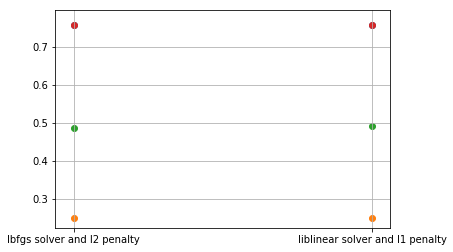

In [75]:
# title for the plots
x_labels = ['lbfgs solver and l2 penalty', 'liblinear solver and l1 penalty']

# Set-up 2x2 grid for plotting.
plt.scatter(x_labels, accuracy, label = 'Accuracy');
plt.scatter(x_labels, f1_score, label = 'f1_score'); 
plt.scatter(x_labels, logloss, label = 'logloss');
plt.scatter(x_labels, jacc_score, label = 'jacc_score');

plt.grid(b=True, axis='both')
plt.xticks(rotation=0);

In [76]:
print ("The best accuracy was: {0:.3f} with {lab}".format(accuracy.max(), lab=x_labels[accuracy.argmax()]))
print ("The best log_loss was: {0:.3f} with {lab}".format(logloss.min(), lab=x_labels[logloss.argmin()]))
print ("The best F1_score was: {0:.3f} with {lab}".format(f1_score.max(), lab=x_labels[f1_score.argmax()]))
print ("The best jacc_score was: {0:.3f} with {lab}".format(jacc_score.max(), lab=x_labels[jacc_score.argmax()]))

The best accuracy was: 0.757 with lbfgs solver and l2 penalty
The best log_loss was: 0.486 with lbfgs solver and l2 penalty
The best F1_score was: 0.250 with lbfgs solver and l2 penalty
The best jacc_score was: 0.757 with lbfgs solver and l2 penalty


# Model Evaluation using Test set

In [77]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [78]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-10-06 15:16:27--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-10-06 15:16:28 (166 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [130]:
test_df = pd.read_csv('loan_test.csv', index_col=0)
test_df = test_df.drop(columns=['Unnamed: 0.1'])  #drop useless col

test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [131]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_X = preprocessing.StandardScaler().fit(test_Feature).transform(test_Feature)
test_X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


array([[ 0.494,  0.928,  3.06 ,  1.977, -1.304,  2.398, -0.798, -0.861],
       [-3.563, -1.704,  0.533, -0.506,  0.767, -0.417, -0.798, -0.861],
       [ 0.494,  0.928,  1.881,  1.977,  0.767, -0.417,  1.254, -0.861],
       [ 0.494,  0.928, -0.983, -0.506,  0.767, -0.417, -0.798,  1.161],
       [-0.665, -0.789, -0.477, -0.506,  0.767,  2.398, -0.798, -0.861]])

In [132]:
test_y = test_df['loan_status'].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [133]:
X_train = preprocessing.StandardScaler().fit(X).transform(X)
y_train = df['loan_status'].values

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [134]:
#BestKNN
neigh = KNeighborsClassifier(n_neighbors=7, weights=weight[0]).fit(X_train,y_train)
yhat = neigh.predict(test_X)
KNN_jacc_score = metrics.jaccard_similarity_score(test_y, yhat)
KNN_logloss = metrics.log_loss(test_y, neigh.predict_proba(test_X))
KNN_f1_score = metrics.f1_score(test_y, yhat, pos_label='PAIDOFF', average='binary')

print("KNN Jaccard index: %.2f" % KNN_jacc_score)
print("KNN F1-score: %.2f" % KNN_f1_score )
print("KNN LogLoss: %.2f" % KNN_logloss)

KNN Jaccard index: 0.74
KNN F1-score: 0.84
KNN LogLoss: 1.12


In [135]:
#BestDT
rfc = RandomForestClassifier(n_estimators=100,
                                max_depth=4,
                                min_samples_split = 0.02,
                                min_samples_leaf = 0.01,
                                max_features='auto')
rfc.fit(X, y_train)
yhat = rfc.predict(test_X)
DT_jacc_score = metrics.jaccard_similarity_score(test_y, yhat)
DT_logloss = metrics.log_loss(test_y, rfc.predict_proba(test_X))
DT_f1_score = metrics.f1_score(test_y, yhat, pos_label='PAIDOFF', average='binary')

print("DT Jaccard index: %.2f" % DT_jacc_score)
print("DT F1-score: %.2f" % DT_f1_score )
print("DT LogLoss: %.2f" % DT_logloss)

DT Jaccard index: 0.74
DT F1-score: 0.85
DT LogLoss: 0.54


In [136]:
#BestSVM
C = 1.0  # SVM regularization parameter

clf =svm.SVC(kernel='poly', degree=3, gamma='auto', C=C)
clf.fit(X_train, y_train)
y_hat = clf.predict(test_X)
SVM_jacc_score = metrics.jaccard_similarity_score(test_y, yhat)
SVM_f1_score = metrics.f1_score(test_y, yhat, pos_label='PAIDOFF', average='binary')

print("SVM Jaccard index: %.2f" % SVM_jacc_score)
print("SVM F1-score: %.2f" % SVM_f1_score )

SVM Jaccard index: 0.74
SVM F1-score: 0.85


In [137]:
#BestLR
C = 10 # LR inverse of regularization strength

lr = LogisticRegressionCV(Cs=C, fit_intercept=True, solver='lbfgs', penalty='l2', cv=5)
lr.fit(X_train, y_train)
y_hat = clf.predict(test_X)
LR_jacc_score = metrics.jaccard_similarity_score(test_y, yhat)
LR_logloss = metrics.log_loss(test_y, lr.predict_proba(test_X))
LR_f1_score = metrics.f1_score(test_y, yhat, pos_label='PAIDOFF', average='binary')

print("LR Jaccard index: %.2f" % LR_jacc_score)
print("LR F1-score: %.2f" % LR_f1_score )
print("LR LogLoss: %.2f" % LR_logloss)

LR Jaccard index: 0.74
LR F1-score: 0.85
LR LogLoss: 0.57


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.74    | 0.84     | 1.12    |
| Decision Tree      | 0.74    | 0.85     | 0.48    |
| SVM                | 0.74    | 0.85     | NA      |
| LogisticRegression | 0.74    | 0.85     | 0.57    |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>